In [7]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the data in folder data
path = "drive/MyDrive/Calculo/dataset/loan"
files = os.listdir(path)
df = pd.DataFrame()
for file in files:
    if file.endswith(".csv"):
        data = pd.read_csv(path + "/" + file)
        df = pd.concat([df, data])

# 1. Geração de **Dados**

A função generate_logistic_data gera dados simulados para uma tarefa de classificação binária.
Os valores de entrada (x) são distribuídos uniformemente no intervalo [-100,100].
Os rótulos (y) são obtidos a partir do dataframe df (representando informações de status de empréstimos).

`Um limiar de 0.5 é usado para categorizar os rótulos em duas classes: 0 e 1. Caso necessário.`

## **Justificativa:**

* Essa abordagem simula um cenário de classificação em que os rótulos derivam de um conjunto de dados existente.

* A transformação de rótulos em binários é comum em tarefas de classificação logística.

In [8]:
# Função para gerar dados simulados para regressão logística simples
def generate_logistic_data(n_points=len(df["loan_status"])):
    x = tf.linspace(-100.0, 100.0, n_points)

    # Função linear para separar as classes
    y = tf.cast(tf.reshape(df["loan_status"].values, (-1, 1)), dtype=tf.float32)  # 0 ou 1 como saída

    # Criando rótulos binários: se y > 0, então classe 1, caso contrário, classe 0
    labels = tf.where(y > 0.5, 1, 0)
    # print(tf.reshape(x, (-1, 1)), tf.reshape(labels, (-1, 1)))
    return tf.reshape(x, (-1, 1)), tf.reshape(labels, (-1, 1))


# Gerando os dados
x, labels = generate_logistic_data()

# **2. Modelo de Regressão Logística**

* A classe LogisticRegressionModel implementa o modelo de regressão logística.
* Os pesos (w) e o bias (b) são inicializados como variáveis treináveis.
* A operação z = w ⋅ x + b calcula os logits, os quais são transformados em probabilidades usando a função sigmoide.

## **Justificativa:**

O modelo simples reflete a formulação matemática da regressão logística:

\begin{align}
P(Y = 1 | X) = σ(w ⋅ x + b), σ(z) \frac{1}{1 + e^{-z}}
    \end{align}

In [9]:
class LogisticRegressionModel(tf.Module):
    def __init__(self):
        # Inicializando pesos e bias
        self.weights = tf.Variable(tf.random.normal(shape=(1, 1)), dtype=tf.float32)
        self.bias = tf.Variable(tf.random.normal(shape=(1,)), dtype=tf.float32)

    def __call__(self, x):
        logits = tf.matmul(x, self.weights) + self.bias
        return tf.sigmoid(logits)

# **3. Função de Custo**

* A função calcula o erro da entropia cruzada binária (Binary Cross-Entropy, BCE).

* Esta métrica compara as probabilidades preditas pelo modelo com os rótulos reais.

## **Justificativa**
A BCE é amplamente utilizada em problemas de classificação binária, pois maximiza a probabilidade logarítmica dos dados observados.

In [10]:
# Função de custo (Binary Cross-Entropy)
def loss_fn(model, x, labels):
    predictions = model(x)
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(labels, predictions))

# **4. Processo de Treinamento**

* A função train utiliza o otimizador Adam para ajustar os pesos e bias do modelo.
* Em cada época, o gradiente da função de custo é calculado e aplicado para minimizar o erro.
* A perda é monitorada a cada 100 épocas para avaliar a convergência.

## **Justificativa**

* O otimizador Adam adapta dinamicamente a taxa de aprendizado, acelerando a convergência.
* O uso de gradientes automatizados simplifica a implementação de backpropagation.

In [16]:
# Treinando o modelo
def train(model, x, labels, epochs=3000, learning_rate=0.00001):
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = loss_fn(model, x, labels)
        gradients = tape.gradient(loss, [model.weights, model.bias])
        optimizer.apply_gradients(zip(gradients, [model.weights, model.bias]))
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy():.4f}")

# **5. Avaliação do Modelo**

A avaliação considera:

* **Acurácia:** proporção de predições corretas.
* **F1-Score:** medida que combina precisão e recall para avaliar o desempenho em classes desbalanceadas.


In [13]:
def evaluate_model(model, x, labels):
    predictions = model(x)
    binary_predictions = tf.round(predictions)

    # Cálculo da acurácia usando a métrica do Keras
    accuracy = tf.keras.metrics.Accuracy()(labels, binary_predictions)

    # Cálculo do F1-Score usando a métrica do Keras
    metricF1 = keras.metrics.F1Score(threshold=0.5)
    metricF1.update_state(labels, binary_predictions)
    f1_score = metricF1.result()

    return accuracy, f1_score

# **6. Instanciando o modelo, treinando e avaliando**

Executa todas as funções necessárias para rodar o modelo.

In [20]:
# Instanciando o modelo e treinando
model = LogisticRegressionModel()
train(model, x, labels)

# Avaliando o modelo
accuracy, f1 = evaluate_model(model, x, labels)


Epoch 0, Loss: 7.7230
Epoch 100, Loss: 7.7227
Epoch 200, Loss: 7.7225
Epoch 300, Loss: 7.7222
Epoch 400, Loss: 7.7219
Epoch 500, Loss: 7.7216
Epoch 600, Loss: 7.7213
Epoch 700, Loss: 7.7210
Epoch 800, Loss: 7.7208
Epoch 900, Loss: 7.7205
Epoch 1000, Loss: 7.7202
Epoch 1100, Loss: 7.7199
Epoch 1200, Loss: 7.7196
Epoch 1300, Loss: 7.7193
Epoch 1400, Loss: 7.7190
Epoch 1500, Loss: 7.7187
Epoch 1600, Loss: 7.7184
Epoch 1700, Loss: 7.7182
Epoch 1800, Loss: 7.7179
Epoch 1900, Loss: 7.7176
Epoch 2000, Loss: 7.7173
Epoch 2100, Loss: 7.7169
Epoch 2200, Loss: 7.7167
Epoch 2300, Loss: 7.7164
Epoch 2400, Loss: 7.7161
Epoch 2500, Loss: 7.7158
Epoch 2600, Loss: 7.7155
Epoch 2700, Loss: 7.7152
Epoch 2800, Loss: 7.7149
Epoch 2900, Loss: 7.7146


# **6. Visualização**

O gráfico ilustra os dados de entrada (x, y) como pontos, enquanto a curva de predição representa a saída sigmoidal do modelo.

Visualizações ajudam a interpretar a separação de classes e a curva de decisão.

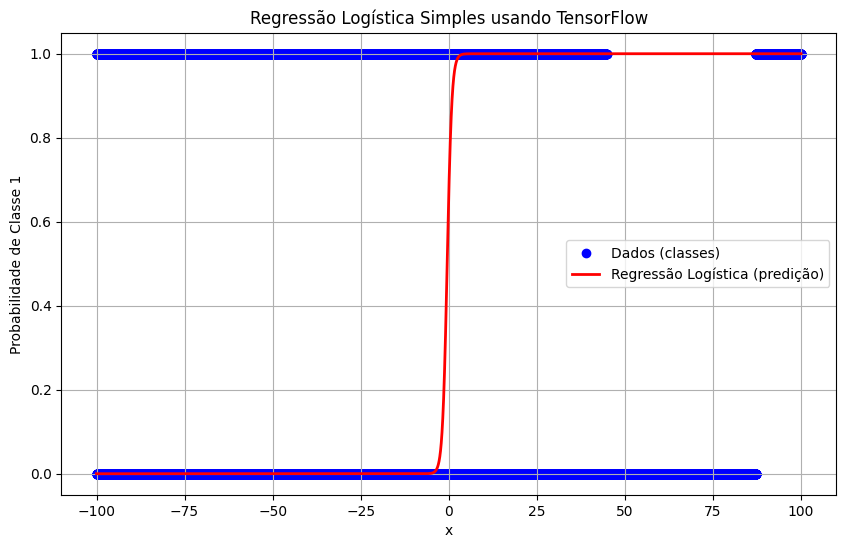

In [21]:
# Plotando os resultados
plt.figure(figsize=(10, 6))
plt.scatter(x, labels, color='blue', label='Dados (classes)')
plt.plot(x, model(x), color='red', linewidth=2, label='Regressão Logística (predição)')
plt.xlabel("x")
plt.ylabel("Probabilidade de Classe 1")
plt.title("Regressão Logística Simples usando TensorFlow")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
print(f"Acurácia: {accuracy:.2f}")
print(f"F1-Score: {f1.numpy()[0]:.2f}")

Acurácia: 0.49
F1-Score: 0.30
